In [596]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from tqdm import tqdm
import os

import scipy.constants
AVO = scipy.constants.Avogadro

In [597]:
GF_THRESHOLD = 0.0e+0
GF_RANGE     = 1.0e-8
GF_DELTAHBYR = 10156.0e+0
GF_T0        = 360.0e+0
GF_TC        = 905.0e+0

#ATM : Standard atmosphere [Pa]  (Source: NIST, 2014)
ATM     = 1.01325e+5
#AIRMW : Average molecular weight of dry air [g/mol]
AIRMW    = 28.97e+0

In [598]:
folder = '/n/home12/hongwei/HONGWEI/GC_aerosol/rundirs/Volcano/Add_H2SO4/geosfp_4x5_gc_timing_Seb_Sigma0.5/'
file = 'GEOSChem.Restart.NO_H2SO4G.20150101_0000z.nc4'
df = xr.open_dataset(folder+file)

In [599]:
lon = df['lon']
lat = df['lat']
lev = df['lev']

Nx = len(lon)
Ny = len(lat)
Nz = len(lev)

In [600]:
# PCENTER_P: dry pressure

hyam = df['hyam']
hybm = df['hybm']
P0 = df['P0']
P = (hyam + hybm * P0) # [hPa]

P.shape

(47,)

In [601]:
# PCENTER = PCENTER_P + e
# moist air pressure = dry air pressure + vapor pressure
# e: partial water vapor pressure

q = df["Met_SPHU1"] # g/kg
q = q/1000.0 # kg/kg

e = q*0.0

for iz in range(Nz):
    # P: pressure [hPa]
    e[0,iz,:,:] = q[0,iz,:,:]*P[iz] / (0.622 + 0.378*q[0,iz,:,:])
    
e.shape

(1, 47, 91, 144)

In [602]:
# water vapor mixing ratio [mol/mol]

SpeciesRst_H2O = (q/18.0) / ((1-q)/28.96) # [kg/kg] => [mol/mol]

SpeciesRst_H2O.shape

(1, 47, 91, 144)

In [603]:
# AD: dry air mass [kg] = volume * density = area * dz * density = area * abs(-dp)/g

Area = df['AREA'] # [m2]
dP = df['Met_DELPDRY']*100.0 # [Pa]
g = 9.8 # [m/s2]

AD = dP*0.0
for iz in range(Nz):
    AD[0,iz,:,:] = Area[:,:] * dP[0,iz,:,:] / g
    
AD.shape


(1, 47, 91, 144)

In [604]:
# TCENTER: temperature
T = df['Met_TMPU1'] # [K]

T.shape

(1, 47, 91, 144)

In [605]:
# Spc_SO4: 

Spc_SO4 = df['SpeciesRst_SO4'] # mol mol-1

Spc_SO4

<xarray.DataArray 'SpeciesRst_SO4' (time: 1, lev: 47, lat: 91, lon: 144)>
[615888 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2016-07-01T00:20:00
  * lev      (lev) float64 0.9925 0.9775 0.9625 ... 0.0004141 0.0001387 3.8e-05
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    long_name:         Dry mixing ratio of species SO4
    units:             mol mol-1 dry
    averaging_method:  instantaneous

# Important: 
## The chemcials (SO4) already has a unit of [mol/mol] in the restart file !!!
## So no need to use INVAIR to convert unit

## InTroposphere is set to be 0 now, which need to be update in the future!!!

In [606]:
SO4_MW_G = 96.0 # g/mol
H2O_MW_G = 18.0

# Calculate H2SO4 gas phase prefactors
GF_INVT0 = 1.0/GF_T0
GF_LOGP0 = -1.0*GF_DELTAHBYR*GF_INVT0 + 16.259
GF_BFACTOR = 0.38/(GF_TC - GF_T0)
GF_ATMCONV = np.log(ATM)


InTroposphere = False

TCENTER = T
PCENTER_P = e*0.0
# P
PCENTER = e*0.0
# PCENTER_P + e
        
for iz in range(Nz):
    PCENTER_P[0,iz,:,:] = P[iz]
    PCENTER[0,iz,:,:] = PCENTER_P[0,iz,:,:] + e[0,iz,:,:]
    
PCENTER.shape, PCENTER_P.shape, e.shape, P.shape

((1, 47, 91, 144), (1, 47, 91, 144), (1, 47, 91, 144), (47,))

In [607]:
PCENTER

<xarray.DataArray 'Met_SPHU1' (time: 1, lev: 47, lat: 91, lon: 144)>
array([[[[9.9252136e+02, 9.9252136e+02, 9.9252136e+02, ...,
          9.9252136e+02, 9.9252136e+02, 9.9252136e+02],
         [9.9254260e+02, 9.9254498e+02, 9.9254736e+02, ...,
          9.9253613e+02, 9.9253809e+02, 9.9254016e+02],
         [9.9258752e+02, 9.9259265e+02, 9.9259918e+02, ...,
          9.9257416e+02, 9.9257855e+02, 9.9258331e+02],
         ...,
         [9.9854651e+02, 9.9853601e+02, 9.9852606e+02, ...,
          9.9853906e+02, 9.9855640e+02, 9.9855298e+02],
         [9.9842920e+02, 9.9843225e+02, 9.9843536e+02, ...,
          9.9840863e+02, 9.9842151e+02, 9.9842828e+02],
         [9.9812939e+02, 9.9812939e+02, 9.9812939e+02, ...,
          9.9812939e+02, 9.9812939e+02, 9.9812939e+02]],

        [[9.7757935e+02, 9.7757935e+02, 9.7757935e+02, ...,
          9.7757935e+02, 9.7757935e+02, 9.7757935e+02],
         [9.7765698e+02, 9.7765839e+02, 9.7765961e+02, ...,
          9.7764929e+02, 9.7765259e+02, 9.7765527e+02],
         [9.7764624e+02, 9.7764520e+02, 9.7764423e+02, ...,
          9.7763629e+02, 9.7764209e+02, 9.7764453e+02],
...
         [1.3867547e-01, 1.3867547e-01, 1.3867547e-01, ...,
          1.3867547e-01, 1.3867547e-01, 1.3867547e-01],
         [1.3867547e-01, 1.3867547e-01, 1.3867547e-01, ...,
          1.3867547e-01, 1.3867547e-01, 1.3867547e-01],
         [1.3867547e-01, 1.3867547e-01, 1.3867547e-01, ...,
          1.3867547e-01, 1.3867547e-01, 1.3867547e-01]],

        [[3.8000137e-02, 3.8000137e-02, 3.8000137e-02, ...,
          3.8000137e-02, 3.8000137e-02, 3.8000137e-02],
         [3.8000148e-02, 3.8000148e-02, 3.8000148e-02, ...,
          3.8000148e-02, 3.8000148e-02, 3.8000148e-02],
         [3.8000148e-02, 3.8000148e-02, 3.8000148e-02, ...,
          3.8000148e-02, 3.8000148e-02, 3.8000148e-02],
         ...,
         [3.8000271e-02, 3.8000271e-02, 3.8000271e-02, ...,
          3.8000271e-02, 3.8000271e-02, 3.8000271e-02],
         [3.8000271e-02, 3.8000271e-02, 3.8000271e-02, ...,
          3.8000271e-02, 3.8000271e-02, 3.8000271e-02],
         [3.8000271e-02, 3.8000271e-02, 3.8000271e-02, ...,
          3.8000271e-02, 3.8000271e-02, 3.8000271e-02]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-01T00:20:00
  * lev      (lev) float64 0.9925 0.9775 0.9625 ... 0.0004141 0.0001387 3.8e-05
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

In [608]:
TCENTER

<xarray.DataArray 'Met_TMPU1' (time: 1, lev: 47, lat: 91, lon: 144)>
[615888 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2016-07-01T00:20:00
  * lev      (lev) float64 0.9925 0.9775 0.9625 ... 0.0004141 0.0001387 3.8e-05
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    long_name:         Instantaneous temperature at time=T
    units:             K
    averaging_method:  instantaneous

In [609]:
# calcualte the gas-liquid partition for H2SO4:
    # TCENTER = State_Met%T(I,J,L).
    # PCENtER = State_Met%PMID(I,J,L): moist air pressure.
    # PCENTER_P = State_Met%PMID_DRY(I,J,L): Dry air partial pressure for part. P calc.
    # AD = State_Met%AD(I,J,L), ! Dry air mass [kg] in grid box
    # InTroposphere = State_Met%InTroposphere(I,J,L)
    # Spc_SO4 = Spc(I,J,L,id_SO4), [mol/mol]
    
    # SO4_MW_G = State_Chm%SpcData(id_SO4)%Info%emMW_g ! g/mol
    

INVAIR = AIRMW / AD # [g/mol]/[kg]
print(INVAIR.shape)

# H2SO4SUM = Spc_SO4 * INVAIR / SO4_MW_G
H2SO4SUM = Spc_SO4
print(H2SO4SUM.shape)

GF_PP = H2SO4SUM * PCENTER_P
print(GF_PP.shape)

GF_INVT = 1.0/TCENTER
print(GF_INVT.shape)

GF_CFACTOR = 1.0 + np.log(GF_T0*GF_INVT) - GF_T0*GF_INVT
print(GF_CFACTOR.shape)

GF_LOGPSULFATE = GF_LOGP0 + GF_DELTAHBYR * (GF_INVT0 - GF_INVT + GF_BFACTOR*GF_CFACTOR)
print(GF_LOGPSULFATE.shape)

GF_LOGPSULFATE = GF_LOGPSULFATE + GF_ATMCONV
print(GF_LOGPSULFATE.shape)

GF_PVAP = 1.0e-2 * np.exp(GF_LOGPSULFATE)
print(GF_PVAP.shape)

GF_DIFF = (GF_PVAP+GF_THRESHOLD) - GF_PP
print(GF_DIFF.shape)


AERFRAC = GF_DIFF*0.0 + 1.0

ix = 9
iy = 22
for iz in range(Nz):
            
    if PCENTER[0,iz,iy,ix]>=100.0:
        AERFRAC[0,iz,iy,ix] = 1.0
                
    elif InTroposphere:
        AERFRAC[0,iz,iy,ix] = 1.0
                
    else:
        if GF_DIFF[0,iz,iy,ix] < 0.0:
            AERFRAC[0,iz,iy,ix] = 1.0
        elif GF_DIFF[0,iz,iy,ix] < GF_RANGE:
            AERFRAC[0,iz,iy,ix] = 1.0 - (GF_DIFF[0,iz,iy,ix]/GF_RANGE)
        else:
            AERFRAC[0,iz,iy,ix] = 0.0

(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)
(1, 47, 91, 144)


In [610]:
Ny

91

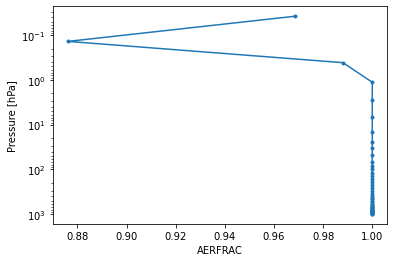

In [611]:
plt.plot(AERFRAC[0,:,iy,ix], P, '.-')

plt.yscale('log')
plt.gca().invert_yaxis()

plt.ylabel('Pressure [hPa]')
plt.xlabel('AERFRAC');


## Partition H2SO4 into Gas and Liquid phases

In [612]:

Spc_H2SO4G = Spc_SO4*0.0
Spc_H2SO4G = Spc_SO4 * (1-AERFRAC)
Spc_SO4_new = Spc_SO4 * AERFRAC

AERFRAC.shape, Spc_SO4.shape

((1, 47, 91, 144), (1, 47, 91, 144))

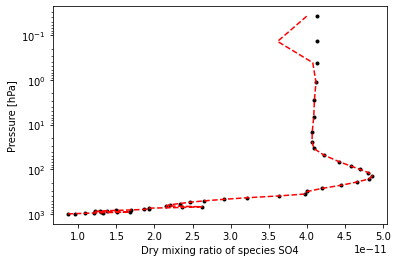

In [613]:

plt.plot(Spc_SO4[0,:,iy,ix], P, 'k.')
plt.plot(Spc_SO4_new[0,:,iy,ix], P, 'r--')

plt.yscale('log')
plt.gca().invert_yaxis()

plt.ylabel('Pressure [hPa]')
plt.xlabel(f'{Spc_SO4.long_name}');

# Asign liquid SO4 to 40-bin

In [614]:
def CARSLAW_DENSITY(M_H2SO4,M_HNO3,TCENTER):
    
    CS = M_H2SO4
    CN = M_HNO3
    T = TCENTER
    
    DENSS=1000.0e+0 + 123.64e+0 * CS-5.6e-4 * CS*T**2 \
          -29.54e+0 * CS**1.5e+0 + 1.814e-4 * CS**1.5e+0 \
          *T**2+2.343e+0 * CS**2  -1.487e-3 * CS**2*T \
          -1.324e-5 * CS**2 * T**2

    DENSN=1000.0e+0 + 85.107e+0 * CN-5.043e-4 * CN*T**2 \
          -18.96e+0 * CN**1.5e+0 + 1.427e-4 * CN**1.5e+0 \
          *T**2+1.458e+0 * CN**2  -1.198e-3 * CN**2*T \
          -9.703e-6 * CN**2 *T**2

    # Error trap for zeros (ckeller, 12/29/17)
    if( CS == 0.0 and CN == 0.0 ):
        SLA_rho = 0.0
    else:
        SLA_rho =1.0e+0 / ((1.0e+0/DENSS*CS/(CS+CN) \
                      +1.0e+0 / DENSN*CN / (CS+CN) ))
    
    return SLA_rho

In [615]:
# ATM : Standard atmosphere [Pa]  (Source: NIST, 2014)
# RSTARG : Molar gas constant [J/K/mol]

KS = [0.0, -21.661e+0, 2724.2e+0, 51.81e+0, -15732.0e+0, 47.004e+0, -6969.0e+0 ,-4.6183e+0]
ATM = 1.01325e+5

M_HNO3 = 0.0e+0
TNY = 1.0e-28

RSTARG = 8.3144598e+0
M_HNO3 = 0.0e+0
    
def TERNARY(PCENTER_in, TCENTER_in, H2OSUM_in, H2SO4SUM_in):
    
    PCENTER = max(PCENTER_in,5.0e+0)
    TCENTER = TCENTER_in
    H2OSUM_IN = max(H2OSUM_in,5.0e-7)
    H2SO4SUM_IN = H2SO4SUM_in
    
    # Calculate partial pressure of H2O & HNO3
    # PCENTER is in hPa, so need to convert ATM from Pa to hPa
    PATMH2O  = H2OSUM_IN  * PCENTER / (ATM*1e-2)

    # Carslaw only valid for 2e-5 < PPH2O < 2e-3 (hPa)
    PATMH2O = max(PATMH2O,1.9738465e-8)
    PATMH2O = min(PATMH2O,1.9738465e-6)
    
    # Determine H2SO4/H2O pure solution concentration
    # Mole fraction of H2SO4 in binary solution
    TMP1 = (KS[1]+KS[2]/TCENTER)**2.0e+0-4.0e+0*(KS[3]+KS[4]/TCENTER)*(KS[5]+KS[6]/TCENTER+KS[7]*np.log(TCENTER)-np.log(PATMH2O))
    if( TMP1 > 0.0 ):
        X_H2SO4_BIN = 1.0e+0/(2.0e+0*(KS[3]+KS[4]/TCENTER))*(-KS[1]-KS[2]/TCENTER-(TMP1)**0.5e+0)
    else:
        X_H2SO4_BIN = 0.0
    
    # Molality (mol H2SO4/kg H2O) in binary solution
    M_H2SO4_BIN = 55.51e+0*X_H2SO4_BIN/(1.0e+0-X_H2SO4_BIN)
    M_H2SO4 = M_H2SO4_BIN
    W_H2SO4 = M_H2SO4_BIN*0.098076e+0/(1.0e+0+M_H2SO4_BIN*0.098076e+0)

    SLA_RHO = CARSLAW_DENSITY(M_H2SO4,M_HNO3,TCENTER)
    
    # Moles of H2SO4 per m3 air
    MOLDENS_H2SO4 = 100.0e+0*PCENTER*H2SO4SUM_IN/(RSTARG*TCENTER)
    print(f'0 0 0: ,{np.array(PCENTER)}, {H2SO4SUM_IN.values}, {RSTARG}, {TCENTER.values}')
    
    # Aerosol mass density in kg/m3 aerosol
    SLA_RHO = CARSLAW_DENSITY(M_H2SO4,M_HNO3,TCENTER)
    
    # Aerosol volume in m3/m3 air
    if( W_H2SO4 < TNY or SLA_RHO < TNY ):
        SLA_VOL = 0.0
    else:
        SLA_VOL = (MOLDENS_H2SO4*98.076/W_H2SO4/SLA_RHO)*1.0e-3
        
    print(f"TERNARY 1: ,{MOLDENS_H2SO4.values}, {W_H2SO4.values}, {SLA_RHO.values}, {SLA_VOL.values}")
        
    return SLA_VOL

In [616]:
# SLA_VR     : SLA volume-effective radius conversion
# SLA_RR     : SLA effective-liquid radius conversion
# SLA_VOL    : Aerosol volume (m3/m3)

SLA_VR = (0.357e-6)*(10.0e+0**(12.0e+0*0.249))
SLA_RR = np.exp(-0.173)


In [617]:
n_aer_bin = 40
den_h2so4=1.8E-12 # pure h2so4 density in g/um^3, used for calculating h2so4 mass/particle !eth_af_dryS
aer_R0=3.9376E-4  # smallest bin's dry sulfate radius in um
aer_pi = np.pi
aer_Vrat = 2.0e+0

aer_mass = np.zeros(n_aer_bin)
aer_dry_rad = np.zeros(n_aer_bin)

for k in range(n_aer_bin):
    if(k==0):
        aer_mass[k]=den_h2so4*4./3.*aer_pi*aer_R0**3 # mass H2SO4/particle in g
        aer_dry_rad[k] = aer_R0
    else:
        aer_mass[k]=aer_mass[k-1]*aer_Vrat # mass H2SO4/particle in g
        aer_dry_rad[k] = (3.0*aer_mass[k]/(4.0*aer_pi*den_h2so4))**(1.0/3.0)


In [618]:
Spc_Bin_0 = Spc_SO4*0.0
Spc_Bin_1 = Spc_SO4*0.0
Spc_Bin_2 = Spc_SO4*0.0
Spc_Bin_3 = Spc_SO4*0.0
Spc_Bin_4 = Spc_SO4*0.0
Spc_Bin_5 = Spc_SO4*0.0
Spc_Bin_6 = Spc_SO4*0.0
Spc_Bin_7 = Spc_SO4*0.0
Spc_Bin_8 = Spc_SO4*0.0
Spc_Bin_9 = Spc_SO4*0.0

Spc_Bin_10 = Spc_SO4*0.0
Spc_Bin_11 = Spc_SO4*0.0
Spc_Bin_12 = Spc_SO4*0.0
Spc_Bin_13 = Spc_SO4*0.0
Spc_Bin_14 = Spc_SO4*0.0
Spc_Bin_15 = Spc_SO4*0.0
Spc_Bin_16 = Spc_SO4*0.0
Spc_Bin_17 = Spc_SO4*0.0
Spc_Bin_18 = Spc_SO4*0.0
Spc_Bin_19 = Spc_SO4*0.0

Spc_Bin_20 = Spc_SO4*0.0
Spc_Bin_21 = Spc_SO4*0.0
Spc_Bin_22 = Spc_SO4*0.0
Spc_Bin_23 = Spc_SO4*0.0
Spc_Bin_24 = Spc_SO4*0.0
Spc_Bin_25 = Spc_SO4*0.0
Spc_Bin_26 = Spc_SO4*0.0
Spc_Bin_27 = Spc_SO4*0.0
Spc_Bin_28 = Spc_SO4*0.0
Spc_Bin_29 = Spc_SO4*0.0

Spc_Bin_30 = Spc_SO4*0.0
Spc_Bin_31 = Spc_SO4*0.0
Spc_Bin_32 = Spc_SO4*0.0
Spc_Bin_33 = Spc_SO4*0.0
Spc_Bin_34 = Spc_SO4*0.0
Spc_Bin_35 = Spc_SO4*0.0
Spc_Bin_36 = Spc_SO4*0.0
Spc_Bin_37 = Spc_SO4*0.0
Spc_Bin_38 = Spc_SO4*0.0
Spc_Bin_39 = Spc_SO4*0.0

In [619]:
# # Generate radius data

# if Nbin==40: 
#     vol_ratio = 2.0
# elif Nbin==150: 
#     vol_ratio = 1.2
# else:
#     print("*** vol_ratio value? ***")
    

# r0 = 3.9376e-4 # um
# v0 = (4.0/3.0)*np.pi*np.power(r0,3) # um^3
# aer_vol_dry = [np.power(vol_ratio,x) * v0 for x in range(Nbin)] #um^3
# aer_vol_dry = np.array(aer_vol_dry)
# aer_r_dry = ( aer_vol_dry / (4/3*np.pi) )**(1/3)


In [620]:
print(np.array(PCENTER_in))

0.038000185


In [621]:
# H2OSUM = SpeciesRst_H2O * INVAIR / H2O_MW_G
# H2SO4SUM = Spc_SO4_new * INVAIR / SO4_MW_G

H2OSUM = SpeciesRst_H2O
H2SO4SUM = Spc_SO4_new

Sigma = 0.55 # 1.82

Wts = np.zeros(n_aer_bin)

R_eff = []

print(f'for lon={lon[ix].values}, lat={lat[iy].values}')
for iz in range(Nz):
            
    # (1) calculate the effective radius
    PCENTER_in = PCENTER[0,iz,iy,ix]
    TCENTER_in = TCENTER[0,iz,iy,ix]
    H2OSUM_in = H2OSUM[0,iz,iy,ix]
    H2SO4SUM_in = H2SO4SUM[0,iz,iy,ix]
            
    if H2SO4SUM_in>0.0 and PCENTER_in<100.0:
                
        if iz==36: print(f'---: {np.array(PCENTER_in)}, {np.array(TCENTER_in)}, {np.array(H2OSUM_in)}, {np.array(H2SO4SUM_in)}')
        VOL_SLA = TERNARY(PCENTER_in, TCENTER_in, H2OSUM_in, H2SO4SUM_in)
            
        RAD_AER_BOX = SLA_VR*SLA_RR*(VOL_SLA**0.249) # m
        R_eff.append(RAD_AER_BOX.values)
        if iz==36: print(f'--- shw: {SLA_VR}, {SLA_RR}, {VOL_SLA.values}, {RAD_AER_BOX.values}')
                
        # (2) set initial Rm and sigma
        Rm = RAD_AER_BOX*1e6/np.exp(5.0/2.0*Sigma**2) # [um]
                
        # (3) set initial unimodal lognormal distribution
        for I_Bin in range(40):
            r  = aer_dry_rad[I_Bin] # [um]
            aer_vol_dry = 4/3 * np.pi * r**3 # [um^3]

            if(I_Bin==0):
                Dr = aer_dry_rad[I_Bin+1] - aer_dry_rad[I_Bin]
            elif(I_Bin==39):
                Dr = aer_dry_rad[I_Bin] - aer_dry_rad[I_Bin-1]
            else:
                Dr = (aer_dry_rad[I_Bin+1] - aer_dry_rad[I_Bin-1])/2.0

            # total particle mass = mass per particle * particle number density
            # Assume density is same in different bins, so mass distribution is
            # same as volume distribution

            # Wts[I_Bin] = aer_mass[I_Bin] * Dr * 1/(Sigma*np.sqrt(2.0*np.pi)) * 1/r \
            #     * np.exp( -1* (np.log(r)-np.log(Rm))**2 / (2.0*Sigma**2) )
            
            ### shw40: important change !!!
            Wts[I_Bin] = (den_h2so4 *aer_vol_dry /98.076 *AVO) \
                        * Dr * 1/(Sigma*np.sqrt(2.0*np.pi)) * 1/r \
                        * np.exp( -1* (np.log(r)-np.log(Rm))**2 / (2.0*Sigma**2) )
            
            
        Spc_Bin_0[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[0]/np.sum(Wts)
        Spc_Bin_1[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[1]/np.sum(Wts)
        Spc_Bin_2[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[2]/np.sum(Wts)
        Spc_Bin_3[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[3]/np.sum(Wts)
        Spc_Bin_4[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[4]/np.sum(Wts)
        Spc_Bin_5[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[5]/np.sum(Wts)
        Spc_Bin_6[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[6]/np.sum(Wts)
        Spc_Bin_7[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[7]/np.sum(Wts)
        Spc_Bin_8[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[8]/np.sum(Wts)
        Spc_Bin_9[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[9]/np.sum(Wts)
            
        Spc_Bin_10[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[10]/np.sum(Wts)
        Spc_Bin_11[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[11]/np.sum(Wts)
        Spc_Bin_12[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[12]/np.sum(Wts)
        Spc_Bin_13[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[13]/np.sum(Wts)
        Spc_Bin_14[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[14]/np.sum(Wts)
        Spc_Bin_15[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[15]/np.sum(Wts)
        Spc_Bin_16[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[16]/np.sum(Wts)
        Spc_Bin_17[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[17]/np.sum(Wts)
        Spc_Bin_18[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[18]/np.sum(Wts)
        Spc_Bin_19[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[19]/np.sum(Wts)  
            
        Spc_Bin_20[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[20]/np.sum(Wts)
        Spc_Bin_21[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[21]/np.sum(Wts)
        Spc_Bin_22[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[22]/np.sum(Wts)
        Spc_Bin_23[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[23]/np.sum(Wts)
        Spc_Bin_24[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[24]/np.sum(Wts)
        Spc_Bin_25[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[25]/np.sum(Wts)
        Spc_Bin_26[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[26]/np.sum(Wts)
        Spc_Bin_27[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[27]/np.sum(Wts)
        Spc_Bin_28[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[28]/np.sum(Wts)
        Spc_Bin_29[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[29]/np.sum(Wts)
            
        Spc_Bin_30[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[30]/np.sum(Wts)
        Spc_Bin_31[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[31]/np.sum(Wts)
        Spc_Bin_32[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[32]/np.sum(Wts)
        Spc_Bin_33[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[33]/np.sum(Wts)
        Spc_Bin_34[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[34]/np.sum(Wts)
        Spc_Bin_35[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[35]/np.sum(Wts)
        Spc_Bin_36[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[36]/np.sum(Wts)
        Spc_Bin_37[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[37]/np.sum(Wts)
        Spc_Bin_38[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[38]/np.sum(Wts)
        Spc_Bin_39[0,iz,iy,ix] = Spc_SO4_new[0,iz,iy,ix] * Wts[39]/np.sum(Wts)
            
        Spc_SO4_new[0,iz,iy,ix] = 0.0
            

for lon=-157.5, lat=-46.0
0 0 0: ,85.43939208984375, 4.587503987796282e-11, 8.3144598, 216.89195251464844
TERNARY 1: ,2.1734874064891352e-10, 0.7107057417304377, 1680.5875701102102, 1.784715115739099e-14
---: 67.45040893554688, 217.8103790283203, 4.467568032850977e-06, 4.424265467872779e-11
0 0 0: ,67.45040893554688, 4.424265467872779e-11, 8.3144598, 217.8103790283203
TERNARY 1: ,1.6478328497708012e-10, 0.7255382499761401, 1697.602510209207, 1.3121382006419432e-14
--- shw: 0.0003472707588883765, 0.8411376148446232, 1.3121382006419432e-14, 1.020733071460491e-07
0 0 0: ,48.28188705444336, 4.2268813449375386e-11, 8.3144598, 218.18563842773438
TERNARY 1: ,1.1249781666910868e-10, 0.7382757498081945, 1713.2797997003408, 8.722880865589769e-15
0 0 0: ,34.27177810668945, 4.094287062161861e-11, 8.3144598, 218.9385986328125
TERNARY 1: ,7.708299039075082e-11, 0.7534877447428614, 1733.1440329722511, 5.7890919836232295e-15
0 0 0: ,24.079822540283203, 4.0696647440885414e-11, 8.3144598, 218.4617156982

In [622]:
R_eff

[array(1.10198562e-07),
 array(1.02073307e-07),
 array(9.22060879e-08),
 array(8.32578655e-08),
 array(7.58106399e-08),
 array(6.68615874e-08),
 array(5.51226833e-08),
 array(5.08600308e-08),
 array(4.99644681e-08),
 array(4.88390806e-08),
 array(4.52081777e-08),
 array(4.75639077e-08)]

In [631]:
num_bin = np.zeros((40))

num_bin[0] = Spc_Bin_0[0,40,iy,ix]
num_bin[1] = Spc_Bin_1[0,40,iy,ix]
num_bin[2] = Spc_Bin_2[0,40,iy,ix]
num_bin[3] = Spc_Bin_3[0,40,iy,ix]
num_bin[4] = Spc_Bin_4[0,40,iy,ix]
num_bin[5] = Spc_Bin_5[0,40,iy,ix]
num_bin[6] = Spc_Bin_6[0,40,iy,ix]
num_bin[7] = Spc_Bin_7[0,40,iy,ix]
num_bin[8] = Spc_Bin_8[0,40,iy,ix]
num_bin[9] = Spc_Bin_9[0,40,iy,ix]

num_bin[10] = Spc_Bin_10[0,40,iy,ix]
num_bin[11] = Spc_Bin_11[0,40,iy,ix]
num_bin[12] = Spc_Bin_12[0,40,iy,ix]
num_bin[13] = Spc_Bin_13[0,40,iy,ix]
num_bin[14] = Spc_Bin_14[0,40,iy,ix]
num_bin[15] = Spc_Bin_15[0,40,iy,ix]
num_bin[16] = Spc_Bin_16[0,40,iy,ix]
num_bin[17] = Spc_Bin_17[0,40,iy,ix]
num_bin[18] = Spc_Bin_18[0,40,iy,ix]
num_bin[19] = Spc_Bin_19[0,40,iy,ix]

num_bin[20] = Spc_Bin_20[0,40,iy,ix]
num_bin[21] = Spc_Bin_21[0,40,iy,ix]
num_bin[22] = Spc_Bin_22[0,40,iy,ix]
num_bin[23] = Spc_Bin_23[0,40,iy,ix]
num_bin[24] = Spc_Bin_24[0,40,iy,ix]
num_bin[25] = Spc_Bin_25[0,40,iy,ix]
num_bin[26] = Spc_Bin_26[0,40,iy,ix]
num_bin[27] = Spc_Bin_27[0,40,iy,ix]
num_bin[28] = Spc_Bin_28[0,40,iy,ix]
num_bin[29] = Spc_Bin_29[0,40,iy,ix]

num_bin[30] = Spc_Bin_30[0,40,iy,ix]
num_bin[31] = Spc_Bin_31[0,40,iy,ix]
num_bin[32] = Spc_Bin_32[0,40,iy,ix]
num_bin[33] = Spc_Bin_33[0,40,iy,ix]
num_bin[34] = Spc_Bin_34[0,40,iy,ix]
num_bin[35] = Spc_Bin_35[0,40,iy,ix]
num_bin[36] = Spc_Bin_36[0,40,iy,ix]
num_bin[37] = Spc_Bin_37[0,40,iy,ix]
num_bin[38] = Spc_Bin_38[0,40,iy,ix]
num_bin[39] = Spc_Bin_39[0,40,iy,ix]

In [632]:
aer_dry_rad

array([3.93760000e-04, 4.96106513e-04, 6.25055038e-04, 7.87520000e-04,
       9.92213025e-04, 1.25011008e-03, 1.57504000e-03, 1.98442605e-03,
       2.50022015e-03, 3.15008000e-03, 3.96885210e-03, 5.00044031e-03,
       6.30016000e-03, 7.93770420e-03, 1.00008806e-02, 1.26003200e-02,
       1.58754084e-02, 2.00017612e-02, 2.52006400e-02, 3.17508168e-02,
       4.00035224e-02, 5.04012800e-02, 6.35016336e-02, 8.00070449e-02,
       1.00802560e-01, 1.27003267e-01, 1.60014090e-01, 2.01605120e-01,
       2.54006534e-01, 3.20028180e-01, 4.03210240e-01, 5.08013069e-01,
       6.40056359e-01, 8.06420480e-01, 1.01602614e+00, 1.28011272e+00,
       1.61284096e+00, 2.03205228e+00, 2.56022544e+00, 3.22568192e+00])

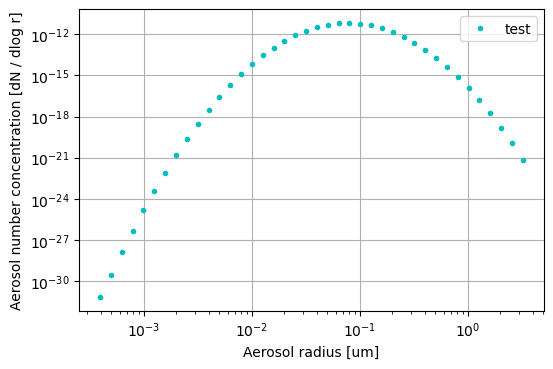

In [633]:
fig = plt.figure(dpi=100)

plt.plot(aer_dry_rad[:], num_bin[:], 'c.', label=f'test')

plt.grid()
plt.xscale("log")
plt.yscale("log")

# plt.ylim(1e-2,1e9)
# plt.xlim(4e-4,1e0)


plt.xlabel('Aerosol radius [um]')
plt.ylabel('Aerosol number concentration [dN / dlog r]');
plt.legend();